In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Reading

In [2]:
# connect to PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname="everything2024",
        user="cis6875",
        password="",
        host="pg.mlds.northwestern.edu",
        port="5432"
    )
    print('connected successfully')

except:
    print('fail to connect')
    
    
# write sql to query data
def query_to_dataframe(query):
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    column_names = [desc[0] for desc in cur.description]
    cur.close()
    return pd.DataFrame(rows, columns=column_names)

# read data
def read_data(file_name):
    limit = 1000000
    offset = 0  
    dfs = [] 
    finish = 0
    
    while True:
        query = f"SELECT * FROM team16.{file_name} LIMIT {limit} OFFSET {offset}"
        df = query_to_dataframe(query)
        
        if df.empty:
            break
    
        dfs.append(df)
        offset += limit
        finish += len(df)
        print(f"Finished reading {finish} rows for {file_name}.")
    
    final_df = pd.concat(dfs, ignore_index=True)
    print(f"Finished reading {file_name}. Total rows {len(final_df)}.")
    
    return final_df

connected successfully


In [3]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000')
#trnsact.to_pickle('trnsact1.pkl')

In [4]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 20000000')
#trnsact.to_pickle('trnsact2.pkl')

In [5]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 40000000')
#trnsact.to_pickle('trnsact3.pkl')

In [6]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 60000000')
#trnsact.to_pickle('trnsact4.pkl')

In [7]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 80000000')
#trnsact.to_pickle('trnsact5.pkl')

In [8]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 100000000')
#trnsact.to_pickle('trnsact6.pkl')

In [9]:
#trnsact = query_to_dataframe('select * from team16.trnsact limit 20000000 offset 120000000')
#trnsact.to_pickle('trnsact7.pkl')

In [ ]:
deptinfo = query_to_dataframe('select * from team16.deptinfo')
skstinfo = query_to_dataframe('select * from team16.skstinfo')
skuinfo = query_to_dataframe('select * from team16.skuinfo')
strinfo = query_to_dataframe('select * from team16.strinfo')
trnsact = query_to_dataframe('select * from team16.trnsact order by random() limit 20000000')

# 2. Data Cleaning

## 2.1 deptinfo table

In [4]:
deptinfo.head()

,dept,deptdesc,bool
0,800,CLINIQUE ...,0
1,801,LESLIE ...,0
2,1100,GARY F ...,0
3,1107,JACQUES ...,0
4,1202,CABERN ...,0


In [5]:
# remove blank space after string
deptinfo['deptdesc'] = deptinfo['deptdesc'].str.strip()
deptinfo.head()

,dept,deptdesc,bool
0,800,CLINIQUE,0
1,801,LESLIE,0
2,1100,GARY F,0
3,1107,JACQUES,0
4,1202,CABERN,0


In [6]:
deptinfo = deptinfo.drop(columns=['bool'])

In [7]:
# check the data types and find missing data
deptinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dept      60 non-null     int64 
 1   deptdesc  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [8]:
# find duplicate rows
deptinfo[deptinfo.duplicated()]

,dept,deptdesc


## 2.2 skstinfo table

In [9]:
skstinfo.head()

,store,sku,cost,retail,bool
0,9209,9679020,20.93,46.0,0
1,9304,9679020,20.93,46.0,0
2,9309,9679020,20.93,46.0,0
3,9404,9679020,20.93,46.0,0
4,9504,9679020,20.93,46.0,0


In [10]:
skstinfo = skstinfo.drop(columns=['bool'])

In [11]:
# check the data types and find missing data
skstinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39230146 entries, 0 to 39230145
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   store   int64  
 1   sku     int64  
 2   cost    float64
 3   retail  float64
dtypes: float64(2), int64(2)
memory usage: 1.2 GB


In [12]:
skstinfo.isnull().sum()

store     0
sku       0
cost      0
retail    0
dtype: int64

In [13]:
# find duplicate rows
skstinfo[skstinfo.duplicated()]

,store,sku,cost,retail


In [14]:
# find the cost outliers that are more than 3 standard deviations away from the mean
cost_mean = skstinfo.cost.mean()
cost_std = skstinfo.cost.std()

skstinfo_outliers_1 = np.abs(skstinfo.cost - cost_mean) > 3 * cost_std
skstinfo.cost[skstinfo_outliers_1].sort_values()

12161934     146.00
6697624      146.00
3549310      146.00
36189732     146.00
3763791      146.00
             ...   
8349526     1872.54
8349528     1872.54
8349527     1872.54
8349524     1872.54
25962723    2700.00
Name: cost, Length: 700651, dtype: float64

In [15]:
# find the retail outliers that are more than 3 standard deviations away from the mean
retail_mean = skstinfo.retail.mean()
retail_std = skstinfo.retail.std()

skstinfo_outliers_2 = np.abs(skstinfo.retail - retail_mean) > 3 * retail_std
skstinfo.retail[skstinfo_outliers_2].sort_values()

16658459     295.32
3824377      295.50
12944663     295.50
19514886     295.98
35758660     295.98
             ...   
8349528     5850.00
8349523     5850.00
8349524     5850.00
8349525     5850.00
25962723    6017.00
Name: retail, Length: 634866, dtype: float64

## 2.3 skuinfo table

In [16]:
skuinfo.head()

,sku,dept,classid,upc,style,color,size,packsize,vendor,brand,bool
0,575,1301,002 ...,000400000575000 ...,28 EJLU82 ...,AFRCN VLT ...,1X ...,1,3313116 ...,EMMA JAM,0
1,579,4505,105 ...,000400000579000 ...,1FK 012863 ...,GENTS HEAT ...,M ...,1,5715232 ...,POLO FAS,0
2,581,9105,221 ...,000400000581000 ...,46T F55KR9 ...,BLACK CHERRY ...,2XT ...,1,2160642 ...,ROUNDTRE,0
3,582,6006,211 ...,000400000582000 ...,1 761NA7 ...,OXFORD BRO ...,095N ...,1,0060904 ...,BROWN SH,0
4,587,2102,909 ...,000400000587000 ...,50782 ...,RED ...,34C ...,1,8226339 ...,CABERNET,0


In [17]:
# remove blank space after string
skuinfo['classid'] = skuinfo['classid'].str.strip()
skuinfo['upc'] = skuinfo['upc'].str.strip()
skuinfo['style'] = skuinfo['style'].str.strip()
skuinfo['color'] = skuinfo['color'].str.strip()
skuinfo['size'] = skuinfo['size'].str.strip()
skuinfo['vendor'] = skuinfo['vendor'].str.strip()
skuinfo.head()

,sku,dept,classid,upc,style,color,size,packsize,vendor,brand,bool
0,575,1301,002,000400000575000,28 EJLU82,AFRCN VLT,1X,1,3313116,EMMA JAM,0
1,579,4505,105,000400000579000,1FK 012863,GENTS HEAT,M,1,5715232,POLO FAS,0
2,581,9105,221,000400000581000,46T F55KR9,BLACK CHERRY,2XT,1,2160642,ROUNDTRE,0
3,582,6006,211,000400000582000,1 761NA7,OXFORD BRO,095N,1,0060904,BROWN SH,0
4,587,2102,909,000400000587000,50782,RED,34C,1,8226339,CABERNET,0


In [18]:
skuinfo = skuinfo.drop(columns=['bool'])

In [19]:
# check the data types and find missing data
skuinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564178 entries, 0 to 1564177
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   sku       1564178 non-null  int64 
 1   dept      1564178 non-null  int64 
 2   classid   1564178 non-null  object
 3   upc       1564178 non-null  object
 4   style     1564178 non-null  object
 5   color     1564178 non-null  object
 6   size      1564178 non-null  object
 7   packsize  1564178 non-null  int64 
 8   vendor    1564178 non-null  object
 9   brand     1564178 non-null  object
dtypes: int64(3), object(7)
memory usage: 119.3+ MB


In [20]:
# find duplicate rows
skuinfo[skuinfo.duplicated()]

,sku,dept,classid,upc,style,color,size,packsize,vendor,brand


In [21]:
skuinfo.packsize.value_counts().sort_index()

packsize
0           36
1      1533541
2         4157
3        14021
4         2927
5           32
6         7253
7           40
8          139
9            3
10         230
11           5
12         602
16           4
18           8
20          19
23           4
24          72
25          44
29           4
36         104
40           8
48          40
50          79
58           6
70           1
75           6
80           1
96           1
100         46
101         79
120          9
190          1
200          2
201         97
250          1
300          5
301         14
401         10
403        300
500         18
501        150
508          5
600          7
601         36
720          4
801          6
999          1
Name: count, dtype: int64

In [22]:
skuinfo[skuinfo.packsize == 999]

,sku,dept,classid,upc,style,color,size,packsize,vendor,brand
268359,1719645,800,009,000400009645171,643N70,N/A,N/A,999,5511283,CLINIQUE


In [23]:
# drop row with packsize=999
skuinfo = skuinfo[skuinfo.packsize != 999]
skuinfo[skuinfo.packsize == 999]

,sku,dept,classid,upc,style,color,size,packsize,vendor,brand


## 2.4 strinfo table

In [24]:
strinfo.head()

,store,city,state,zip,bool
0,2,ST. PETERSBURG ...,FL,33710,0
1,3,ST. LOUIS ...,MO,63126,0
2,4,LITTLE ROCK ...,AR,72201,0
3,7,FORT WORTH ...,TX,76137,0
4,9,TEMPE ...,AZ,85281,0


In [25]:
# remove blank space after string
strinfo['city'] = strinfo['city'].str.strip()
strinfo.head()

,store,city,state,zip,bool
0,2,ST. PETERSBURG,FL,33710,0
1,3,ST. LOUIS,MO,63126,0
2,4,LITTLE ROCK,AR,72201,0
3,7,FORT WORTH,TX,76137,0
4,9,TEMPE,AZ,85281,0


In [26]:
strinfo = strinfo.drop(columns=['bool'])

In [27]:
# check the data types and find missing data
strinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   store   453 non-null    int64 
 1   city    453 non-null    object
 2   state   453 non-null    object
 3   zip     453 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 14.3+ KB


In [28]:
# find duplicate rows
strinfo[strinfo.duplicated()]

,store,city,state,zip


## 2.5 trnsact table

In [29]:
trnsact.head()

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic,bool
0,9616344,8102,11,1500,2005-07-26,504100020,829600528,R,1,79.50,19.87,19.87,205 ...,0
1,8686285,1704,210,4200,2004-09-04,581200197,290208950,P,1,24.99,24.99,24.99,028 ...,0
2,7974222,3103,100,700,2005-02-16,258800024,0,P,1,69.00,17.25,17.25,400 ...,0
3,9222690,709,900,1400,2004-08-08,55800047,0,P,1,49.00,12.25,12.25,281 ...,0
4,5799240,7007,370,2700,2005-08-21,796900067,0,P,1,85.00,85.00,85.00,205 ...,0


In [30]:
# remove blank space after string
trnsact['mic'] = trnsact['mic'].str.strip()
trnsact.head()

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic,bool
0,9616344,8102,11,1500,2005-07-26,504100020,829600528,R,1,79.50,19.87,19.87,205,0
1,8686285,1704,210,4200,2004-09-04,581200197,290208950,P,1,24.99,24.99,24.99,028,0
2,7974222,3103,100,700,2005-02-16,258800024,0,P,1,69.00,17.25,17.25,400,0
3,9222690,709,900,1400,2004-08-08,55800047,0,P,1,49.00,12.25,12.25,281,0
4,5799240,7007,370,2700,2005-08-21,796900067,0,P,1,85.00,85.00,85.00,205,0


In [31]:
trnsact = trnsact.drop(columns=['bool'])

In [32]:
# check the data types and find missing data
trnsact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   sku       int64  
 1   store     int64  
 2   register  int64  
 3   trannum   int64  
 4   saledate  object 
 5   seq       int64  
 6   interid   int64  
 7   stype     object 
 8   quantity  int64  
 9   orgprice  float64
 10  amt       float64
 11  amt2      float64
 12  mic       object 
dtypes: float64(3), int64(7), object(3)
memory usage: 1.9+ GB


In [33]:
trnsact.isnull().sum()

sku         0
store       0
register    0
trannum     0
saledate    0
seq         0
interid     0
stype       0
quantity    0
orgprice    0
amt         0
amt2        0
mic         0
dtype: int64

In [34]:
# convert saledate to datetime format
trnsact.saledate = pd.to_datetime(trnsact.saledate, format='%y/%m/%d')
trnsact.dtypes

sku                  int64
store                int64
register             int64
trannum              int64
saledate    datetime64[ns]
seq                  int64
interid              int64
stype               object
quantity             int64
orgprice           float64
amt                float64
amt2               float64
mic                 object
dtype: object

In [35]:
# find duplicate rows
trnsact[trnsact.duplicated()]

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic


In [36]:
trnsact.quantity.value_counts()

quantity
1     19999998
70           1
80           1
Name: count, dtype: int64

In [37]:
trnsact[(trnsact.quantity == 70) | (trnsact.quantity == 80)]

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic
12265329,5776383,5304,10,1100,2005-03-20,367600023,0,R,70,32.0,0.15,10.5,366
13933784,5937725,8404,460,300,2005-03-22,465800046,0,R,80,34.0,0.41,32.8,142


In [38]:
# find the orgprice outliers that are more than 3 standard deviations away from the mean
orgprice_mean = trnsact.orgprice.mean()
orgprice_std = trnsact.orgprice.std()

trnsact_outliers_1 = np.abs(trnsact.orgprice - orgprice_mean) > 3 * orgprice_std
trnsact.orgprice[trnsact_outliers_1].sort_values()

4362969      157.75
19402628     157.75
15356762     157.75
5957337      157.75
15619241     157.75
             ...   
13668243    1200.00
8620980     1200.00
9124745     1200.00
2214960     1200.00
5384186     1365.00
Name: orgprice, Length: 285201, dtype: float64

In [39]:
# find the amt outliers that are more than 3 standard deviations away from the mean
amt_mean = trnsact.amt.mean()
amt_std = trnsact.amt.std()

trnsact_outliers_2 = np.abs(trnsact.amt - amt_mean) > 3 * amt_std
trnsact.amt[trnsact_outliers_2].sort_values()

9753889      106.5
18941396     106.5
10202543     106.5
12141554     106.5
12147919     106.5
             ...  
14680230    1200.0
3580571     1200.0
5384186     1228.0
7466899     4004.0
12605515    5005.0
Name: amt, Length: 220582, dtype: float64

In [40]:
# view saledate range
saledate_range = trnsact['saledate'].min(), trnsact['saledate'].max()
saledate_range

(Timestamp('2004-08-01 00:00:00'), Timestamp('2005-08-27 00:00:00'))

## 2.6 merged table

In [41]:
# merge str, sku, dept, trnsact, and skstinfo dataframe
sku_dept = pd.merge(skuinfo, deptinfo, on='dept', how='left')
trnsact_sku_dept = pd.merge(trnsact, sku_dept, on='sku', how='left')
trnsact_sku_dept_str = pd.merge(trnsact_sku_dept, strinfo, on='store', how='left')
trnsact_sku_dept_str_skst = pd.merge(trnsact_sku_dept_str, skstinfo, on=['store', 'sku'], how='left')
trnsact_sku_dept_str_skst.head()

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,...,size,packsize,vendor,brand,deptdesc,city,state,zip,cost,retail
0,9616344,8102,11,1500,2005-07-26,504100020,829600528,R,1,79.50,...,L,1,5715232,POLO FAS,POLOMEN,LAFAYETTE,LA,70503,NaN,NaN
1,8686285,1704,210,4200,2004-09-04,581200197,290208950,P,1,24.99,...,XL,1,0934938,KIDS HEA,ELLEN T,NASHVILLE,TN,37211,NaN,NaN
2,7974222,3103,100,700,2005-02-16,258800024,0,P,1,69.00,...,095M,1,3816210,FRANCO S,BRIOSO,WICHITA,KS,67209,NaN,NaN
3,9222690,709,900,1400,2004-08-08,55800047,0,P,1,49.00,...,9,1,7312464,APPAREL,ESPRIT,GLENDALE,AZ,85308,NaN,NaN
4,5799240,7007,370,2700,2005-08-21,796900067,0,P,1,85.00,...,XL,1,5715232,POLO FAS,POLOMEN,THE WOODLANDS,TX,77380,42.5,85.0


In [42]:
# check missing values
trnsact_sku_dept_str_skst.isnull().sum()

sku               0
store             0
register          0
trannum           0
saledate          0
seq               0
interid           0
stype             0
quantity          0
orgprice          0
amt               0
amt2              0
mic               0
dept              0
classid           0
upc               0
style             0
color             0
size              0
packsize          0
vendor            0
brand             0
deptdesc          0
city              0
state             0
zip               0
cost        8657502
retail      8657502
dtype: int64

In [43]:
# fill missing values of cost and retail using median cost and retail of each sku
sku_median = skstinfo.groupby('sku')[['cost', 'retail']].median().reset_index()
sku_median.columns = ['sku', 'avg_cost', 'avg_retail']

trnsact_sku_dept_str_skst = pd.merge(trnsact_sku_dept_str_skst, sku_median, on='sku', how='left')
trnsact_sku_dept_str_skst['cost'] = trnsact_sku_dept_str_skst['cost'].fillna(trnsact_sku_dept_str_skst['avg_cost'])
trnsact_sku_dept_str_skst['retail'] = trnsact_sku_dept_str_skst['retail'].fillna(trnsact_sku_dept_str_skst['avg_retail'])
trnsact_sku_dept_str_skst = trnsact_sku_dept_str_skst.drop(columns=['avg_cost', 'avg_retail'])

# check missing values again
trnsact_sku_dept_str_skst.isnull().sum()

sku               0
store             0
register          0
trannum           0
saledate          0
seq               0
interid           0
stype             0
quantity          0
orgprice          0
amt               0
amt2              0
mic               0
dept              0
classid           0
upc               0
style             0
color             0
size              0
packsize          0
vendor            0
brand             0
deptdesc          0
city              0
state             0
zip               0
cost        4289497
retail      4289497
dtype: int64

In [44]:
# fill remaining missing values using orgprice and the median proportion of cost regarding retail price
trnsact_sku_dept_str_skst["retail"] =trnsact_sku_dept_str_skst["retail"].fillna(trnsact_sku_dept_str_skst["orgprice"])
trnsact_sku_dept_str_skst["cost"] =trnsact_sku_dept_str_skst["cost"].fillna(trnsact_sku_dept_str_skst["orgprice"]*(sku_median['avg_cost']/sku_median['avg_retail']).median())

# check missing values again
trnsact_sku_dept_str_skst.isnull().sum()

sku         0
store       0
register    0
trannum     0
saledate    0
seq         0
interid     0
stype       0
quantity    0
orgprice    0
amt         0
amt2        0
mic         0
dept        0
classid     0
upc         0
style       0
color       0
size        0
packsize    0
vendor      0
brand       0
deptdesc    0
city        0
state       0
zip         0
cost        0
retail      0
dtype: int64

In [45]:
# save the cleaned data
deptinfo.to_pickle('deptinfo.pkl')
skstinfo.to_pickle('skstinfo.pkl')
skuinfo.to_pickle('skuinfo.pkl')
strinfo.to_pickle('strinfo.pkl')
trnsact.to_pickle('trnsact.pkl')
trnsact_sku_dept_str_skst.to_pickle('trnsact_sku_dept_str_skst.pkl')

# 3. Exploratory Data Analysis

In [2]:
deptinfo = pd.read_pickle('deptinfo.pkl')
skstinfo = pd.read_pickle('skstinfo.pkl')
skuinfo = pd.read_pickle('skuinfo.pkl')
strinfo = pd.read_pickle('strinfo.pkl')
trnsact = pd.read_pickle('trnsact.pkl')
trnsact_sku_dept_str_skst = pd.read_pickle('trnsact_sku_dept_str_skst.pkl')

## 3.1 Summary Statistics

In [3]:
skstinfo[['cost', 'retail']].describe()

,cost,retail
count,3.923015e+07,3.923015e+07
mean,2.415759e+01,4.333249e+01
std,4.056547e+01,8.392405e+01
min,0.000000e+00,0.000000e+00
25%,9.000000e+00,1.299000e+01
50%,1.536000e+01,2.450000e+01
75%,2.676000e+01,4.500000e+01
max,2.700000e+03,6.017000e+03


In [4]:
# number of brands
skuinfo.brand.value_counts()

brand
POLO FAS     130994
BROWN SH      52178
ENZO ANG      49121
LIZ CLAI      43723
ROUNDTRE      39466
              ...  
JESARA/W          1
EL PRESI          1
VERA BRA          1
TRANS WO          1
BEAU IDE          1
Name: count, Length: 1952, dtype: int64

In [5]:
# number of stores in each city
strinfo.city.value_counts()

city
LITTLE ROCK       15
GILBERT            7
OLATHE             7
SAN ANTONIO        7
HOUSTON            7
                  ..
MONROE             1
CEDAR PARK         1
POCATELLO          1
MERRITT ISLAND     1
CHEYENNE           1
Name: count, Length: 299, dtype: int64

In [6]:
# number of stores in each state
strinfo.state.value_counts()

state
TX    79
FL    48
AR    27
AZ    26
OH    25
NC    24
LA    22
MO    20
TN    19
GA    16
OK    15
KS    15
CO    14
KY    14
AL    13
VA    10
CA     8
SC     8
MS     7
UT     6
NM     6
IA     5
NV     5
NE     4
MT     3
NJ     3
ID     3
IL     3
NY     2
IN     2
WY     1
Name: count, dtype: int64

In [7]:
trnsact.head()

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic
0,9616344,8102,11,1500,2005-07-26,504100020,829600528,R,1,79.50,19.87,19.87,205
1,8686285,1704,210,4200,2004-09-04,581200197,290208950,P,1,24.99,24.99,24.99,028
2,7974222,3103,100,700,2005-02-16,258800024,0,P,1,69.00,17.25,17.25,400
3,9222690,709,900,1400,2004-08-08,55800047,0,P,1,49.00,12.25,12.25,281
4,5799240,7007,370,2700,2005-08-21,796900067,0,P,1,85.00,85.00,85.00,205


In [8]:
trnsact[['orgprice', 'amt', 'amt2']].describe()

,orgprice,amt,amt2
count,2.000000e+07,2.000000e+07,2.000000e+07
mean,3.677897e+01,2.462687e+01,2.462688e+01
std,4.030308e+01,2.726364e+01,2.726364e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.600000e+01,9.900000e+00,9.900000e+00
50%,2.800000e+01,1.800000e+01,1.800000e+01
75%,4.800000e+01,3.100000e+01,3.100000e+01
max,1.365000e+03,5.005000e+03,5.005000e+03


## 3.2 Data Visualization

https://github.com/NUMLDS/MLDS-400-2024-Team16/blob/main/EDA.pdf

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='cost', ylabel='retail'>

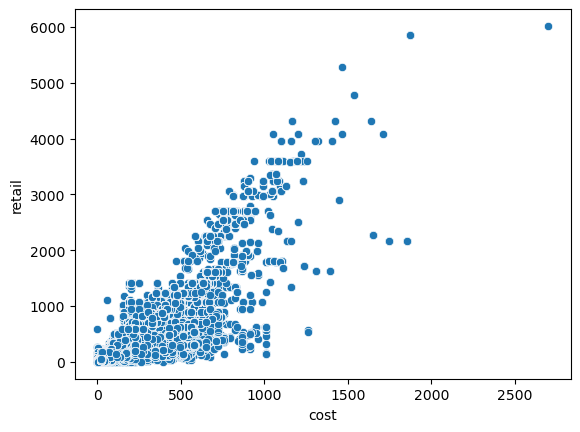

In [10]:
sns.scatterplot(data=skstinfo, x='cost', y='retail')

it seems that there is a positive correlation between cost and retail price.

In [10]:
skstinfo_mean = skstinfo.groupby('store')[['cost', 'retail']].mean().reset_index().sort_values(by='retail')

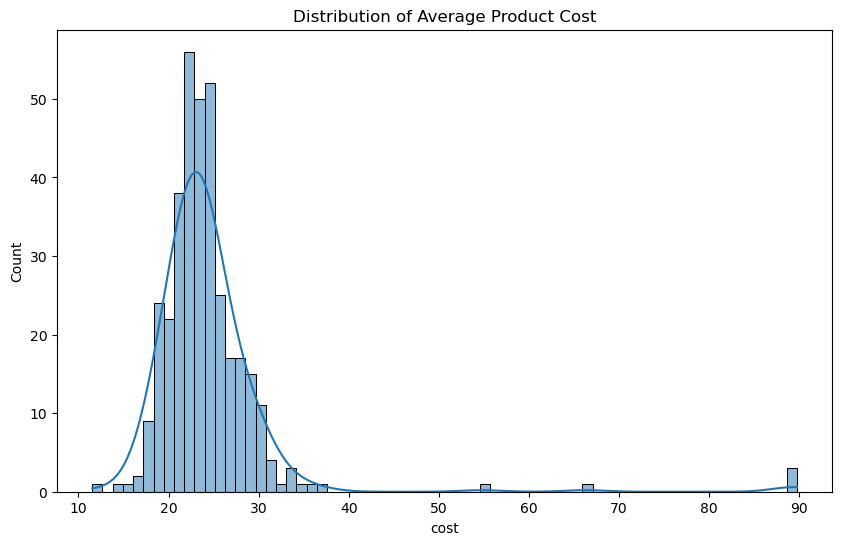

In [11]:
# distribution of average product cost of each store
plt.figure(figsize=(10, 6))
sns.histplot(data=skstinfo_mean, x='cost', kde=True)
plt.title("Distribution of Average Product Cost")
plt.show()

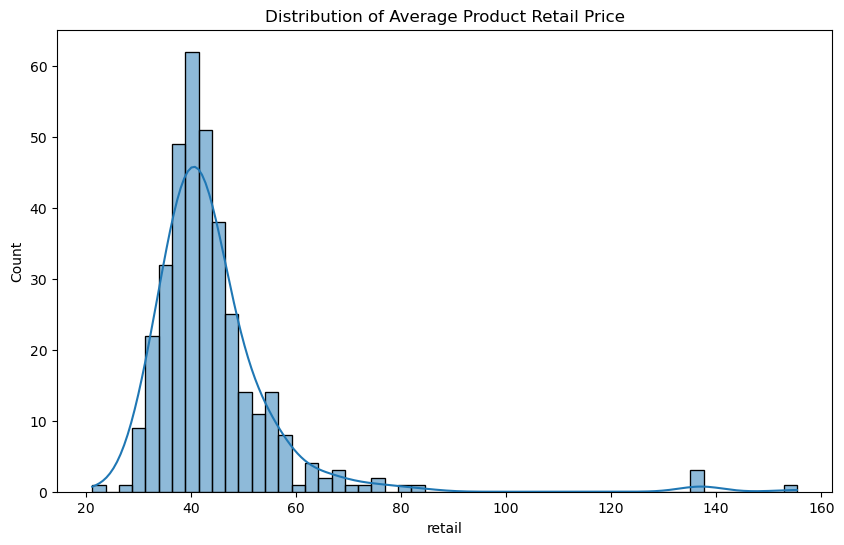

In [12]:
# distribution of average product retail price of each store
plt.figure(figsize=(10, 6))
sns.histplot(data=skstinfo_mean, x='retail', kde=True)
plt.title("Distribution of Average Product Retail Price")
plt.show()

In [13]:
trnsact.stype.value_counts(normalize=True)

stype
P    0.923343
R    0.076657
Name: proportion, dtype: float64

In [14]:
trnsact['year'] = trnsact.saledate.dt.year
trnsact['month'] = trnsact.saledate.dt.month
trnsact['month_of_year'] = trnsact.saledate.dt.to_period('M')
trnsact.head()

,sku,store,register,trannum,saledate,seq,interid,stype,quantity,orgprice,amt,amt2,mic,year,month,month_of_year
0,9616344,8102,11,1500,2005-07-26,504100020,829600528,R,1,79.50,19.87,19.87,205,2005,7,2005-07
1,8686285,1704,210,4200,2004-09-04,581200197,290208950,P,1,24.99,24.99,24.99,028,2004,9,2004-09
2,7974222,3103,100,700,2005-02-16,258800024,0,P,1,69.00,17.25,17.25,400,2005,2,2005-02
3,9222690,709,900,1400,2004-08-08,55800047,0,P,1,49.00,12.25,12.25,281,2004,8,2004-08
4,5799240,7007,370,2700,2005-08-21,796900067,0,P,1,85.00,85.00,85.00,205,2005,8,2005-08


In [15]:
# number of transactions made in each month
trnsact[['year', 'month']].value_counts().sort_index()

year  month
2004  8        1370155
      9        1483282
      10       1391001
      11       1167296
      12       2214242
2005  1        1480252
      2        1876622
      3        1480833
      4        1501460
      5        1276479
      6        1310778
      7        1840934
      8        1606666
Name: count, dtype: int64

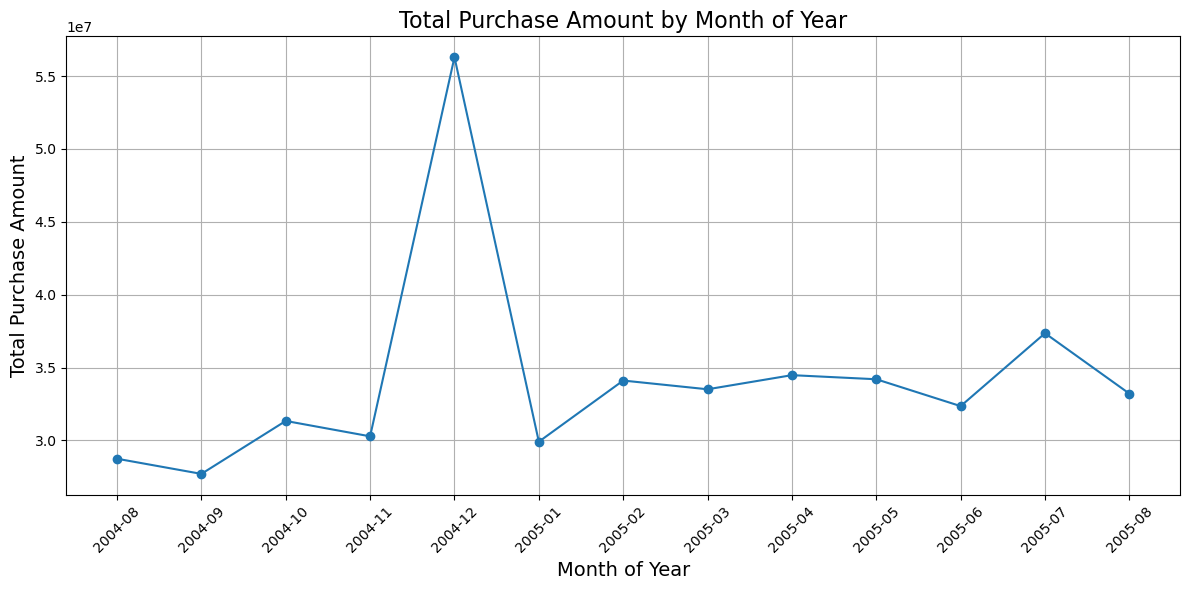

In [16]:
# view total purchase amount by month of year
month_of_year_purchase_totals = trnsact[trnsact.stype == 'P'].groupby('month_of_year')['amt2'].sum().reset_index().sort_values('month_of_year')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(month_of_year_purchase_totals['month_of_year'].astype(str), month_of_year_purchase_totals['amt2'], marker='o')
plt.title('Total Purchase Amount by Month of Year', fontsize=16)
plt.xlabel('Month of Year', fontsize=14)
plt.ylabel('Total Purchase Amount', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

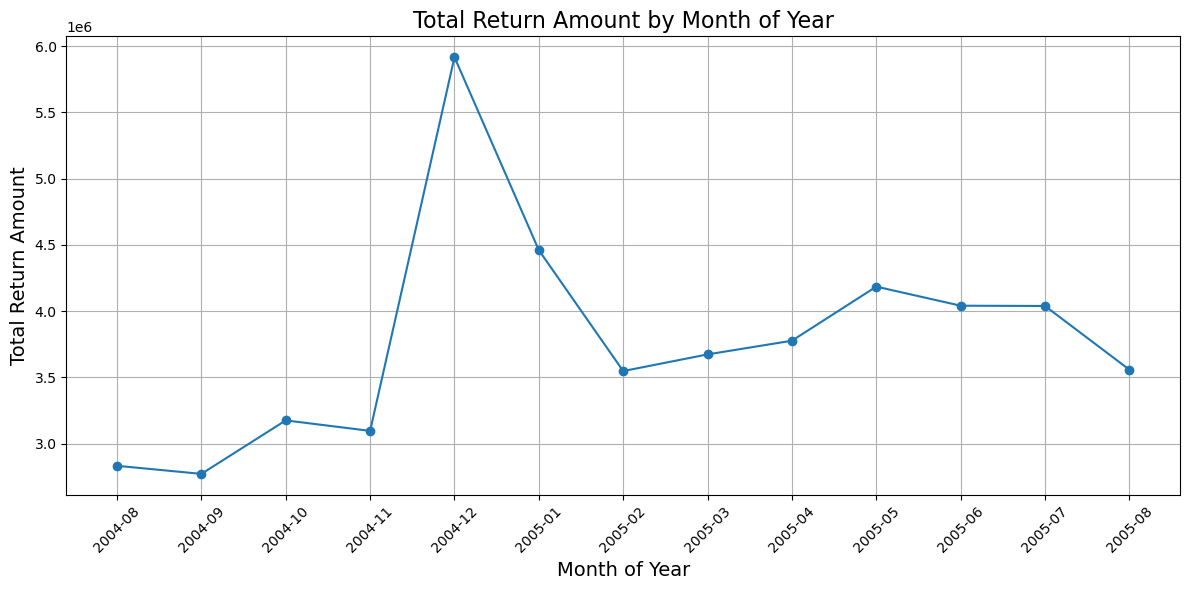

In [17]:
# view total return amount by month of year
month_of_year_return_totals = trnsact[trnsact.stype == 'R'].groupby('month_of_year')['amt2'].sum().reset_index().sort_values('month_of_year')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(month_of_year_return_totals['month_of_year'].astype(str), month_of_year_return_totals['amt2'], marker='o')
plt.title('Total Return Amount by Month of Year', fontsize=16)
plt.xlabel('Month of Year', fontsize=14)
plt.ylabel('Total Return Amount', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

2004-12 has the highest purchase and return amount

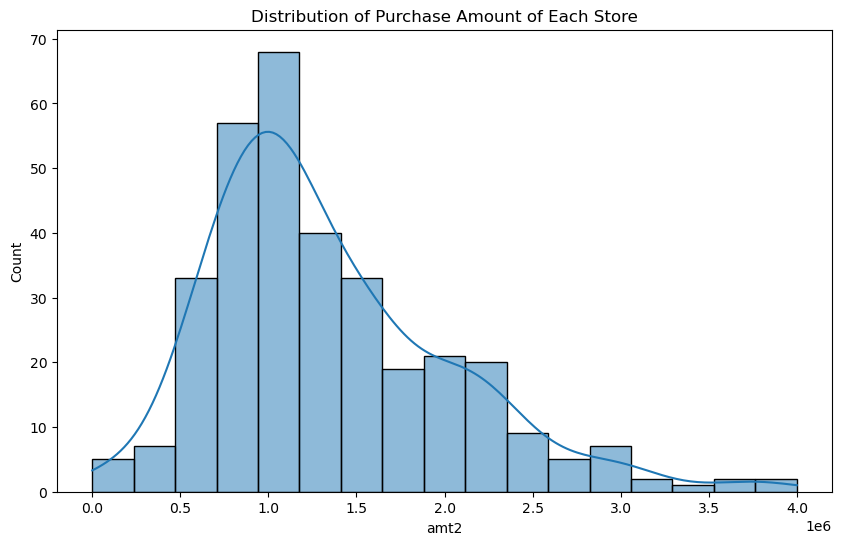

In [18]:
# distribution of total purchase amount of each store
store_purchase = trnsact_sku_dept_str_skst[trnsact_sku_dept_str_skst.stype == 'P'].groupby('store')['amt2'].sum().reset_index().sort_values('amt2')

plt.figure(figsize=(10, 6))
sns.histplot(data=store_purchase, x='amt2', kde=True)
plt.title("Distribution of Purchase Amount of Each Store")
plt.show()

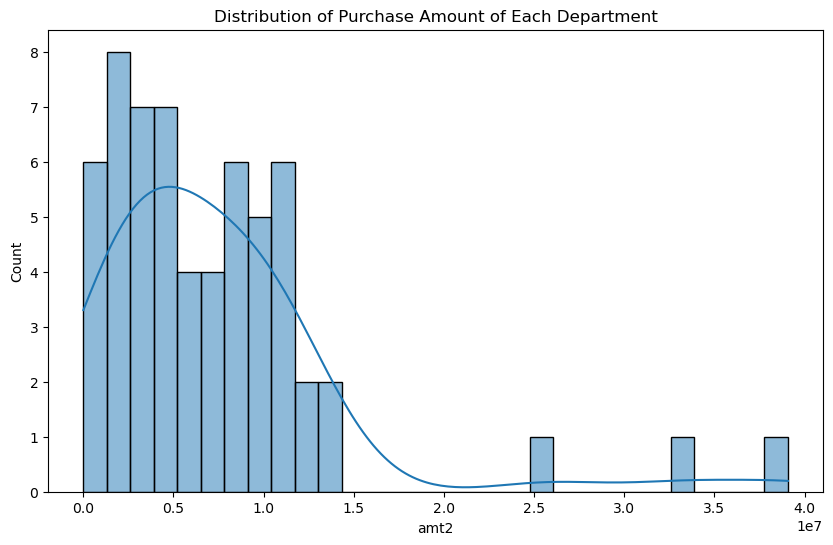

In [19]:
# distribution of total purchase amount of each department
dept_purchase = trnsact_sku_dept_str_skst[trnsact_sku_dept_str_skst.stype == 'P'].groupby('dept')['amt2'].sum().reset_index().sort_values('amt2')

plt.figure(figsize=(10, 6))
sns.histplot(data=dept_purchase, x='amt2', kde=True, bins=30)
plt.title("Distribution of Purchase Amount of Each Department")
plt.show()

# 4. Feature Engineering

Our goal is to predict monthly sales of a product based on sku and store information.

In [20]:
# view transaction date range
trnsact_sku_dept_str_skst['saledate'].min(), trnsact_sku_dept_str_skst['saledate'].max()

(Timestamp('2004-08-01 00:00:00'), Timestamp('2005-08-27 00:00:00'))

In [21]:
# create year and month features
trnsact_sku_dept_str_skst['year'] = trnsact_sku_dept_str_skst.saledate.dt.year
trnsact_sku_dept_str_skst['month'] = trnsact_sku_dept_str_skst.saledate.dt.month
trnsact_sku_dept_str_skst[['year', 'month']].value_counts().sort_index()

year  month
2004  8        1370155
      9        1483282
      10       1391001
      11       1167296
      12       2214242
2005  1        1480252
      2        1876622
      3        1480833
      4        1501460
      5        1276479
      6        1310778
      7        1840934
      8        1606666
Name: count, dtype: int64

there are two August, we will drop data in August 2005 to avoid double monthly sales

In [22]:
# drop data in August 2005
trnsact_sku_dept_str_skst = trnsact_sku_dept_str_skst[~((trnsact_sku_dept_str_skst['year'] == 2005) & (trnsact_sku_dept_str_skst['month'] == 8))]
trnsact_sku_dept_str_skst[['year', 'month']].value_counts().sort_index()

year  month
2004  8        1370155
      9        1483282
      10       1391001
      11       1167296
      12       2214242
2005  1        1480252
      2        1876622
      3        1480833
      4        1501460
      5        1276479
      6        1310778
      7        1840934
Name: count, dtype: int64

In [23]:
# aggregate and merge tables
monthly_sales = (
    trnsact_sku_dept_str_skst[trnsact_sku_dept_str_skst['stype'] == 'P'] # only purchase data
    .groupby(['sku', 'store', 'month'])
    .agg({
        'amt2': 'mean',
        'cost': 'mean',
        'retail': 'mean',
        'quantity': 'sum'
    })
    .reset_index()
)

monthly_sales = pd.merge(monthly_sales, skuinfo, on='sku', how='left')
monthly_sales = pd.merge(monthly_sales, strinfo, on='store', how='left')

# drop irrelevant columns
monthly_sales = monthly_sales.drop(columns=['classid', 'upc', 'style', 'vendor'])

monthly_sales.head()

,sku,store,month,amt2,cost,retail,quantity,dept,color,size,packsize,brand,city,state,zip
0,3,2804,4,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,KNOXVILLE,TN,37919
1,3,3403,3,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,SALINA,KS,67401
2,3,3802,12,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,JENSEN BEACH,FL,34957
3,3,4403,4,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,LINCOLN,NE,68505
4,3,8404,7,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,TULSA,OK,74133


In [24]:
monthly_sales.isnull().sum()

sku         0
store       0
month       0
amt2        0
cost        0
retail      0
quantity    0
dept        0
color       0
size        0
packsize    0
brand       0
city        0
state       0
zip         0
dtype: int64

In [25]:
monthly_sales['color'].value_counts()

color
BLACK         897013
WHITE         698143
MULTI         261273
PINK          211215
RED           195948
               ...  
BLUE/BROWN         1
17-RUBY SH         1
GY/DKBLU F         1
TDL BL/ONY         1
26961430           1
Name: count, Length: 36320, dtype: int64

In [26]:
# categorize color
color_categories = {
    "BLACK": ["BLACK", "001BLACK", "BLACKNESS", "BLK", "ONYX", "JET", "BLACK LE", "BLACK LEAT", "RL BLACK", "OBSIDIAN", "CHARCOAL"],
    "WHITE": ["WHITE", "100WHITE", "BRIGHT WHITE", "STAR WHITE", "WHISPERWHITE", "WHT", "NO COLOR", "CLEAR", "IVORY", "CREAM", "OFF WHITE", "BONE"],
    "RED": ["RED", "TARTAN RED", "600RED", "BURGUNDY", "CHOCOLATE"],
    "BLUE": ["BLUE", "NAVY", "NEWPORT NA", "INDIGO", "DENIM", "AQUA", "TURQ", "TEAL", "INDIGO", "CYAN", "PERIWINKLE"],
    "GREEN": ["GREEN", "OLIVE", "LIME", "SAGE", "JADE", "MOSS"],
    "YELLOW": ["YELLOW", "GOLD", "BEIGE", "NUDE", "FAWN", "CAMEL", "SAND", "TAUPE", "AMBER", "HONEY", "MAIZE"],
    "BROWN": ["BROWN", "NATURAL", "CHOCOLATE", "TAN", "BEIGE", "MOCHA", "CAMEL"],
    "PINK": ["PINK", "LILAC", "PURPLE", "ROSE BEIGE", "FUSCHIA", "MAGENTA", "BLUSH"],
    "ORANGE": ["ORANGE", "CORAL", "APRICOT", "PEACH"],
    "GREY": ["SILVER", "GREY", "PLATINUM", "PEWTER", "GRAY", "SLATE"]
}

color_map = {color: category for category, colors in color_categories.items() for color in colors}
monthly_sales['color_category'] = monthly_sales['color'].map(color_map).fillna('OTHER')
monthly_sales['color_category'].value_counts()

color_category
OTHER     9344564
BLACK     1416973
WHITE     1114603
BLUE       527238
PINK       324193
YELLOW     279339
RED        271152
BROWN      248756
GREY       191596
GREEN      168112
ORANGE      78419
Name: count, dtype: int64

In [27]:
monthly_sales.head()

,sku,store,month,amt2,cost,retail,quantity,dept,color,size,packsize,brand,city,state,zip,color_category
0,3,2804,4,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,KNOXVILLE,TN,37919,WHITE
1,3,3403,3,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,SALINA,KS,67401,WHITE
2,3,3802,12,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,JENSEN BEACH,FL,34957,WHITE
3,3,4403,4,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,LINCOLN,NE,68505,WHITE
4,3,8404,7,30.0,123.36,440.0,1,6505,WHISPERWHITE,P8EA,1,TURNBURY,TULSA,OK,74133,WHITE


In [28]:
# select predictor and response variables
predictors = ['month', 'cost', 'retail', 'color_category', 'packsize', 'state']
target = 'amt2'

# one-hot encoding for categorical variables
monthly_sales['month'] = monthly_sales['month'].astype('category')
categorical_columns = ['month', 'color_category', 'state']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_data = encoder.fit_transform(monthly_sales[categorical_columns])

# scale numerical variables
numerical_columns = ['cost', 'retail', 'packsize']
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(monthly_sales[numerical_columns])

In [29]:
# define X and y
X = np.hstack([scaled_numerical_data, encoded_categorical_data])
y = monthly_sales[target]

# add interaction and polynomial features
#poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
#X = poly.fit_transform(X)

# 5. ML Model Training and Evaluation

## 5.1 Linear Regression

In [30]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [61]:
# evaluate the model
linear_pred = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_pred)
linear_r2 = r2_score(y_test, linear_pred)

print(f"Linear Regression - Mean Squared Error: {linear_mse}")
print(f"Linear Regression - R-squared: {linear_r2}")

Linear Regression - Mean Squared Error: 292.90540818176873
Linear Regression - R-squared: 0.6311536165959849


## 5.2 Ridge Regression

In [33]:
# train ridge regression model
alpha_values = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge_model = Ridge()
ridge_grid_search = GridSearchCV(ridge_model, alpha_values, scoring='neg_mean_squared_error', cv=5)
ridge_grid_search.fit(X_train, y_train)

best_ridge_alpha = ridge_grid_search.best_params_['alpha']
ridge_best_model = Ridge(alpha=best_ridge_alpha)
ridge_best_model.fit(X_train, y_train)

Ridge(alpha=100)

In [34]:
# evaluate ridge model
ridge_pred = ridge_best_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Ridge Regression - Best Alpha: {best_ridge_alpha}")
print(f"Ridge Regression - Mean Squared Error: {ridge_mse}")
print(f"Ridge Regression - R-squared: {ridge_r2}")

Ridge Regression - Best Alpha: 100
Ridge Regression - Mean Squared Error: 292.9053094842322
Ridge Regression - R-squared: 0.6311537408826262


## 5.3 Lasso Regression

In [62]:
# train lasso regression model
alpha_values = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
lasso_model = Lasso()
lasso_grid_search = GridSearchCV(lasso_model, alpha_values, scoring='neg_mean_squared_error', cv=5)
lasso_grid_search.fit(X_train, y_train)

best_lasso_alpha = lasso_grid_search.best_params_['alpha']
lasso_best_model = Lasso(alpha=best_lasso_alpha)
lasso_best_model.fit(X_train, y_train)

Lasso(alpha=0.01)

In [63]:
# evaluate lasso model
lasso_pred = lasso_best_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Lasso Regression - Best Alpha: {best_lasso_alpha}")
print(f"Lasso Regression - Mean Squared Error: {lasso_mse}")
print(f"Lasso Regression - R-squared: {lasso_r2}")

Lasso Regression - Best Alpha: 0.01
Lasso Regression - Mean Squared Error: 293.05482216291404
Lasso Regression - R-squared: 0.6309654643630933


## 5.4 LightGBM

In [43]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 11171956, number of used features: 52
[LightGBM] [Info] Start training from score 25.438716


LGBMRegressor()

In [44]:
# evaluate LightGBM model
lgb_pred = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"LightGBM - Mean Squared Error: {lgb_mse}")
print(f"LightGBM - R-squared: {lgb_r2}")

LightGBM - Mean Squared Error: 192.57167815247303
LightGBM - R-squared: 0.7575006638713108


## 5.5 XGBoost

In [39]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
# evaluate xgboost model
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost - Mean Squared Error: {xgb_mse}")
print(f"XGBoost - R-squared: {xgb_r2}")

XGBoost - Mean Squared Error: 195.9856323863216
XGBoost - R-squared: 0.7532015808325967
